# EDA
#### Will Jarrard (wej5ar) Abhi Dommalapati (ad4bu), Sebastian Ranasinghe (sar2jf)

In [56]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%cd /project/ds5559/h_and_m/
from pyspark.sql import SparkSession
from pyspark.sql import Row
# spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "100g") \
    .appName('my-cool-app') \
    .getOrCreate()

/project/ds5559/h_and_m


In [57]:
customers = spark.read.csv('/project/ds5559/h_and_m/customers.csv',  inferSchema=True, header = True)
articles = spark.read.csv('/project/ds5559/h_and_m/articles.csv',  inferSchema=True, header = True)
transactions_train = spark.read.csv('/project/ds5559/h_and_m/transactions_train.csv',  inferSchema=True, header = True)

In [58]:
df = transactions_train.join(customers, on = 'customer_id', how = 'inner').join(articles, on = 'article_id', how = 'inner')
# df.write.parquet("./data.parquet") 

In [59]:
df.printSchema()

root
 |-- article_id: integer (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- t_dat: string (nullable = true)
 |-- price: double (nullable = true)
 |-- sales_channel_id: integer (nullable = true)
 |-- FN: double (nullable = true)
 |-- Active: double (nullable = true)
 |-- club_member_status: string (nullable = true)
 |-- fashion_news_frequency: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- product_code: integer (nullable = true)
 |-- prod_name: string (nullable = true)
 |-- product_type_no: integer (nullable = true)
 |-- product_type_name: string (nullable = true)
 |-- product_group_name: string (nullable = true)
 |-- graphical_appearance_no: integer (nullable = true)
 |-- graphical_appearance_name: string (nullable = true)
 |-- colour_group_code: integer (nullable = true)
 |-- colour_group_name: string (nullable = true)
 |-- perceived_colour_value_id: integer (nullable = true)
 |-- perceived_colour_value_

In [60]:
# df=spark.read.parquet("data.parquet")

### Number of records

In [61]:
df.count()

31788324

### Number of columns

In [62]:
len(df.columns)

35

In [63]:
df.columns

['article_id',
 'customer_id',
 't_dat',
 'price',
 'sales_channel_id',
 'FN',
 'Active',
 'club_member_status',
 'fashion_news_frequency',
 'age',
 'postal_code',
 'product_code',
 'prod_name',
 'product_type_no',
 'product_type_name',
 'product_group_name',
 'graphical_appearance_no',
 'graphical_appearance_name',
 'colour_group_code',
 'colour_group_name',
 'perceived_colour_value_id',
 'perceived_colour_value_name',
 'perceived_colour_master_id',
 'perceived_colour_master_name',
 'department_no',
 'department_name',
 'index_code',
 'index_name',
 'index_group_no',
 'index_group_name',
 'section_no',
 'section_name',
 'garment_group_no',
 'garment_group_name',
 'detail_desc']

### Subset to 2020 Data

In [64]:
from pyspark.sql.functions import from_unixtime, unix_timestamp, year, month, col, date_format

# Need to make it a string so we can turn it into unix timestamp
df =  df.withColumn('t_dat', df['t_dat'].cast('string'))

# Used https://stackoverflow.com/questions/53285032/how-do-i-convert-timestamp-to-unix-format-with-pyspark
# and https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.from_unixtime.html
df = df.withColumn('date', from_unixtime(unix_timestamp('t_dat', 'yyyy-MM-dd')))

# This is to get the date then year so that we only use the year 2020
df = df.withColumn('year', year(col('date')))
df = df[df['year'] == 2020]
#transactions_train.show(5)
price = df.select("price")
price.show(5)
articles = df.groupby('article_id').count()
articles.show(5)

# Get count by transaction so we can use it for ALS modeling
#df = df.groupby('customer_id', 'article_id').count()
#df.show(5)

+--------------------+
|               price|
+--------------------+
|0.031762711864406774|
|0.022016949152542376|
|0.016932203389830508|
|0.016932203389830508|
|0.025406779661016947|
+--------------------+
only showing top 5 rows

+----------+-----+
|article_id|count|
+----------+-----+
| 809835001|  501|
| 624486010|  392|
| 490176001| 1404|
| 814684002|  202|
| 841238001|  584|
+----------+-----+
only showing top 5 rows



### Statistical Summary of Product Name

In [65]:
df.select('prod_name').distinct().count()

28926

In [66]:
from pyspark.sql.functions import col, desc
df.groupBy('prod_name').count().orderBy('count').sort(desc("count")).show(10,truncate=False)

+---------------------------+-----+
|prod_name                  |count|
+---------------------------+-----+
|Timeless Midrise Brief     |74662|
|Jade HW Skinny Denim TRS   |68328|
|Tilly (1)                  |56688|
|Pluto RW slacks (1)        |45625|
|Luna skinny RW             |39466|
|Shake it in Balconette     |39460|
|Primo slacks               |39200|
|Tilda tank                 |39194|
|Cat Tee.                   |39077|
|Simple as That Triangle Top|35993|
+---------------------------+-----+
only showing top 10 rows



### Statistical Summary of Predictor Variables

In [67]:
df.describe("price").show()

+-------+--------------------+
|summary|               price|
+-------+--------------------+
|  count|            10980132|
|   mean|0.027155150482678525|
| stddev|0.017326580752706763|
|    min|3.389830508474576E-5|
|    max|  0.5067796610169492|
+-------+--------------------+



In [68]:
df.describe("age").show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|          10940434|
|   mean| 35.21693289315579|
| stddev|13.014627808510072|
|    min|                16|
|    max|                99|
+-------+------------------+



In [69]:
df.groupBy('product_group_name').count().orderBy('count').sort(desc("count")).show(10,truncate=False)

+------------------+-------+
|product_group_name|count  |
+------------------+-------+
|Garment Upper body|3942299|
|Garment Lower body|2446417|
|Garment Full body |1384796|
|Swimwear          |1094544|
|Underwear         |973634 |
|Accessories       |507147 |
|Shoes             |241317 |
|Socks & Tights    |204275 |
|Nightwear         |106430 |
|Unknown           |71023  |
+------------------+-------+
only showing top 10 rows



In [70]:
df.groupBy('colour_group_name').count().orderBy('count').sort(desc("count")).show(10,truncate=False)

+-----------------+-------+
|colour_group_name|count  |
+-----------------+-------+
|Black            |3628137|
|White            |1292709|
|Dark Blue        |529338 |
|Light Beige      |511924 |
|Blue             |417358 |
|Beige            |399221 |
|Light Pink       |353195 |
|Light Blue       |347879 |
|Off White        |333948 |
|Greenish Khaki   |314209 |
+-----------------+-------+
only showing top 10 rows



In [71]:
df.groupBy('garment_group_name').count().orderBy('count').sort(desc("count")).show(10,truncate=False)

+------------------+-------+
|garment_group_name|count  |
+------------------+-------+
|Jersey Fancy      |1842708|
|Jersey Basic      |1247202|
|Under-, Nightwear |1122450|
|Swimwear          |1084004|
|Trousers          |1006089|
|Blouses           |890429 |
|Dresses Ladies    |778573 |
|Accessories       |526835 |
|Knitwear          |514411 |
|Trousers Denim    |421934 |
+------------------+-------+
only showing top 10 rows



In [72]:
df.groupBy('department_name').count().orderBy('count').sort(desc("count")).show(10,truncate=False)

+-------------------+-------+
|department_name    |count  |
+-------------------+-------+
|Swimwear           |1073933|
|Jersey             |601447 |
|Trouser            |588812 |
|Blouse             |579569 |
|Jersey Basic       |551022 |
|Basic 1            |452122 |
|Dress              |448016 |
|Jersey fancy       |440830 |
|Expressive Lingerie|396853 |
|Knitwear           |346536 |
+-------------------+-------+
only showing top 10 rows



In [73]:
df.groupBy('index_name').count().orderBy('count').sort(desc("count")).show(10,truncate=False)

+------------------------------+-------+
|index_name                    |count  |
+------------------------------+-------+
|Ladieswear                    |4499780|
|Divided                       |2391230|
|Lingeries/Tights              |2202598|
|Ladies Accessories            |604471 |
|Menswear                      |585240 |
|Sport                         |493164 |
|Children Sizes 134-170        |73054  |
|Baby Sizes 50-98              |63277  |
|Children Sizes 92-140         |48733  |
|Children Accessories, Swimwear|18585  |
+------------------------------+-------+



In [74]:
df.groupBy('fashion_news_frequency').count().orderBy('count').sort(desc("count")).show(10,truncate=False)

+----------------------+-------+
|fashion_news_frequency|count  |
+----------------------+-------+
|NONE                  |6202387|
|Regularly             |4752025|
|null                  |24043  |
|Monthly               |1677   |
+----------------------+-------+



In [75]:
df.groupBy('perceived_colour_value_name').count().orderBy('count').sort(desc("count")).show(10,truncate=False)

+---------------------------+-------+
|perceived_colour_value_name|count  |
+---------------------------+-------+
|Dark                       |4787272|
|Dusty Light                |2135056|
|Light                      |1846473|
|Medium Dusty               |1400677|
|Bright                     |457140 |
|Medium                     |350320 |
|Undefined                  |3047   |
|Unknown                    |147    |
+---------------------------+-------+



In [76]:
df.groupBy('graphical_appearance_name').count().orderBy('count').sort(desc("count")).show(10,truncate=False)

+-------------------------+-------+
|graphical_appearance_name|count  |
+-------------------------+-------+
|Solid                    |6574985|
|All over pattern         |1271794|
|Denim                    |751467 |
|Melange                  |525067 |
|Other structure          |401124 |
|Stripe                   |393268 |
|Check                    |173690 |
|Embroidery               |143734 |
|Lace                     |118474 |
|Placement print          |110332 |
+-------------------------+-------+
only showing top 10 rows



### Graphs

In [77]:
#var = ['article_id','price', 'age', 'product_group_name', 'colour_group_name', 'garment_group_name', 'department_name', 'index_name', 'fashion_news_frequency', 'perceived_colour_value_name', 'graphical_appearance_name']
plot_data = df.sample(.003).toPandas()

In [78]:
plot_data

,article_id,customer_id,t_dat,price,sales_channel_id,FN,Active,club_member_status,fashion_news_frequency,age,...,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,date,year
0,201219001,3ffdeb13b42ef0a09e043c66ddaf8765f9dfcade6e4af5...,2020-09-21,0.025407,2,NaN,NaN,ACTIVE,NONE,30.0,...,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,Fine-knit tights with an elasticated waist.,2020-09-21 00:00:00,2020
1,201219001,98f0bc3581818ff26e742d4d5060b864643c39f3702ae4...,2020-01-04,0.025407,1,1.0,1.0,ACTIVE,Regularly,49.0,...,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,Fine-knit tights with an elasticated waist.,2020-01-04 00:00:00,2020
2,241412052,46c9b7f1e3a9e292bc4e9dafd32bee0ee379a59c0e09a3...,2020-03-12,0.015237,2,NaN,NaN,ACTIVE,NONE,28.0,...,Divided,2,Divided,58,Divided Selected,1009,Trousers,Leggings in patterned jersey with an elasticat...,2020-03-12 00:00:00,2020
3,241412052,8c3e7dce756f3adcad254bb4f86b6714c9425be3799099...,2020-03-03,0.015237,2,1.0,1.0,ACTIVE,Regularly,26.0,...,Divided,2,Divided,58,Divided Selected,1009,Trousers,Leggings in patterned jersey with an elasticat...,2020-03-03 00:00:00,2020
4,322017029,8c96dcce81b1b2fc7f27c76a318e149f6038cb3c8c41ba...,2020-01-13,0.011610,1,1.0,1.0,ACTIVE,Regularly,53.0,...,Ladies Accessories,1,Ladieswear,66,Womens Small accessories,1019,Accessories,Small umbrella with a telescopic handle and a ...,2020-01-13 00:00:00,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32845,887465001,ee1f8ece1361e174693f6c98915efdfbfa49d5800eac50...,2020-03-05,0.033881,2,NaN,NaN,ACTIVE,NONE,18.0,...,Divided,2,Divided,53,Divided Collection,1005,Jersey Fancy,Cropped top in smocked jersey made partly from...,2020-03-05 00:00:00,2020
32846,898295001,15627af9d9aa73142fe4faa0bdb770219e04b5ee77b947...,2020-04-17,0.008458,2,NaN,NaN,ACTIVE,NONE,20.0,...,Ladies Accessories,1,Ladieswear,66,Womens Small accessories,1019,Accessories,Two pairs of metal hoop earrings in different ...,2020-04-17 00:00:00,2020
32847,905401003,678eb32e9cd9fd8bec337fa184fe2e3a59839527fb8f17...,2020-08-23,0.050831,2,NaN,NaN,ACTIVE,NONE,54.0,...,Menswear,3,Menswear,20,Contemporary Smart,1005,Jersey Fancy,Shirt jacket in sturdy jersey with a cutaway c...,2020-08-23 00:00:00,2020
32848,923534006,7017e3fc1cfa208e7f2aded51675a78b66f7874392ae30...,2020-09-17,0.016932,2,NaN,NaN,ACTIVE,NONE,54.0,...,Ladieswear,1,Ladieswear,11,Womens Tailoring,1005,Jersey Fancy,Top in jersey made from recycled polyester wit...,2020-09-17 00:00:00,2020


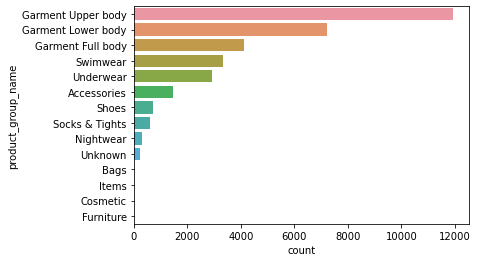

In [82]:
ax = sns.countplot(y="product_group_name", data=plot_data, order = plot_data['product_group_name'].value_counts().index)
plt.show()

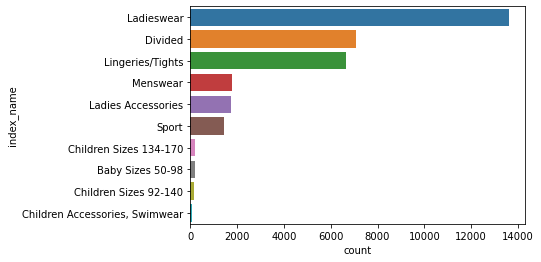

In [83]:
ax = sns.countplot(y="index_name", data=plot_data, order = plot_data["index_name"].value_counts().index)
plt.show()

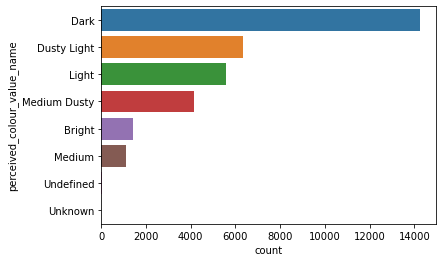

In [84]:
ax = sns.countplot(y="perceived_colour_value_name", data=plot_data, order = plot_data["perceived_colour_value_name"].value_counts().index)
plt.show()

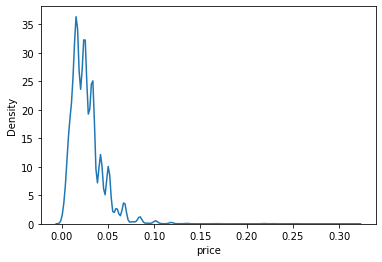

In [85]:
ax = sns.kdeplot(x = "price", data=plot_data)
plt.show()

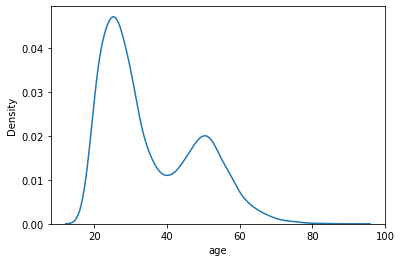

In [86]:
ax = sns.kdeplot(x = "age", data=plot_data)
plt.show()

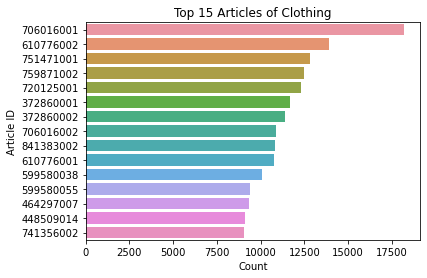

In [89]:
top_articles = articles.orderBy('count').sort(desc("count")).take(15)
top_articles = spark.createDataFrame(top_articles)
article_data = top_articles.toPandas()
ax = sns.barplot(x = "count", y = "article_id", order = article_data["article_id"], data = article_data, orient="h")
ax.set_xlabel("Count")
ax.set_ylabel("Article ID")
ax.set_title("Top 15 Articles of Clothing")
plt.show()

In [114]:
from PIL import Image
import glob
image_list = []
for filename in glob.glob('/project/ds5559/h_and_m/images/070/0706016001.jpg'):
    im=Image.open(filename)
    image_list.append(im)
for filename in glob.glob('/project/ds5559/h_and_m/images/037/0372860001.jpg'):
    im=Image.open(filename)
    image_list.append(im)

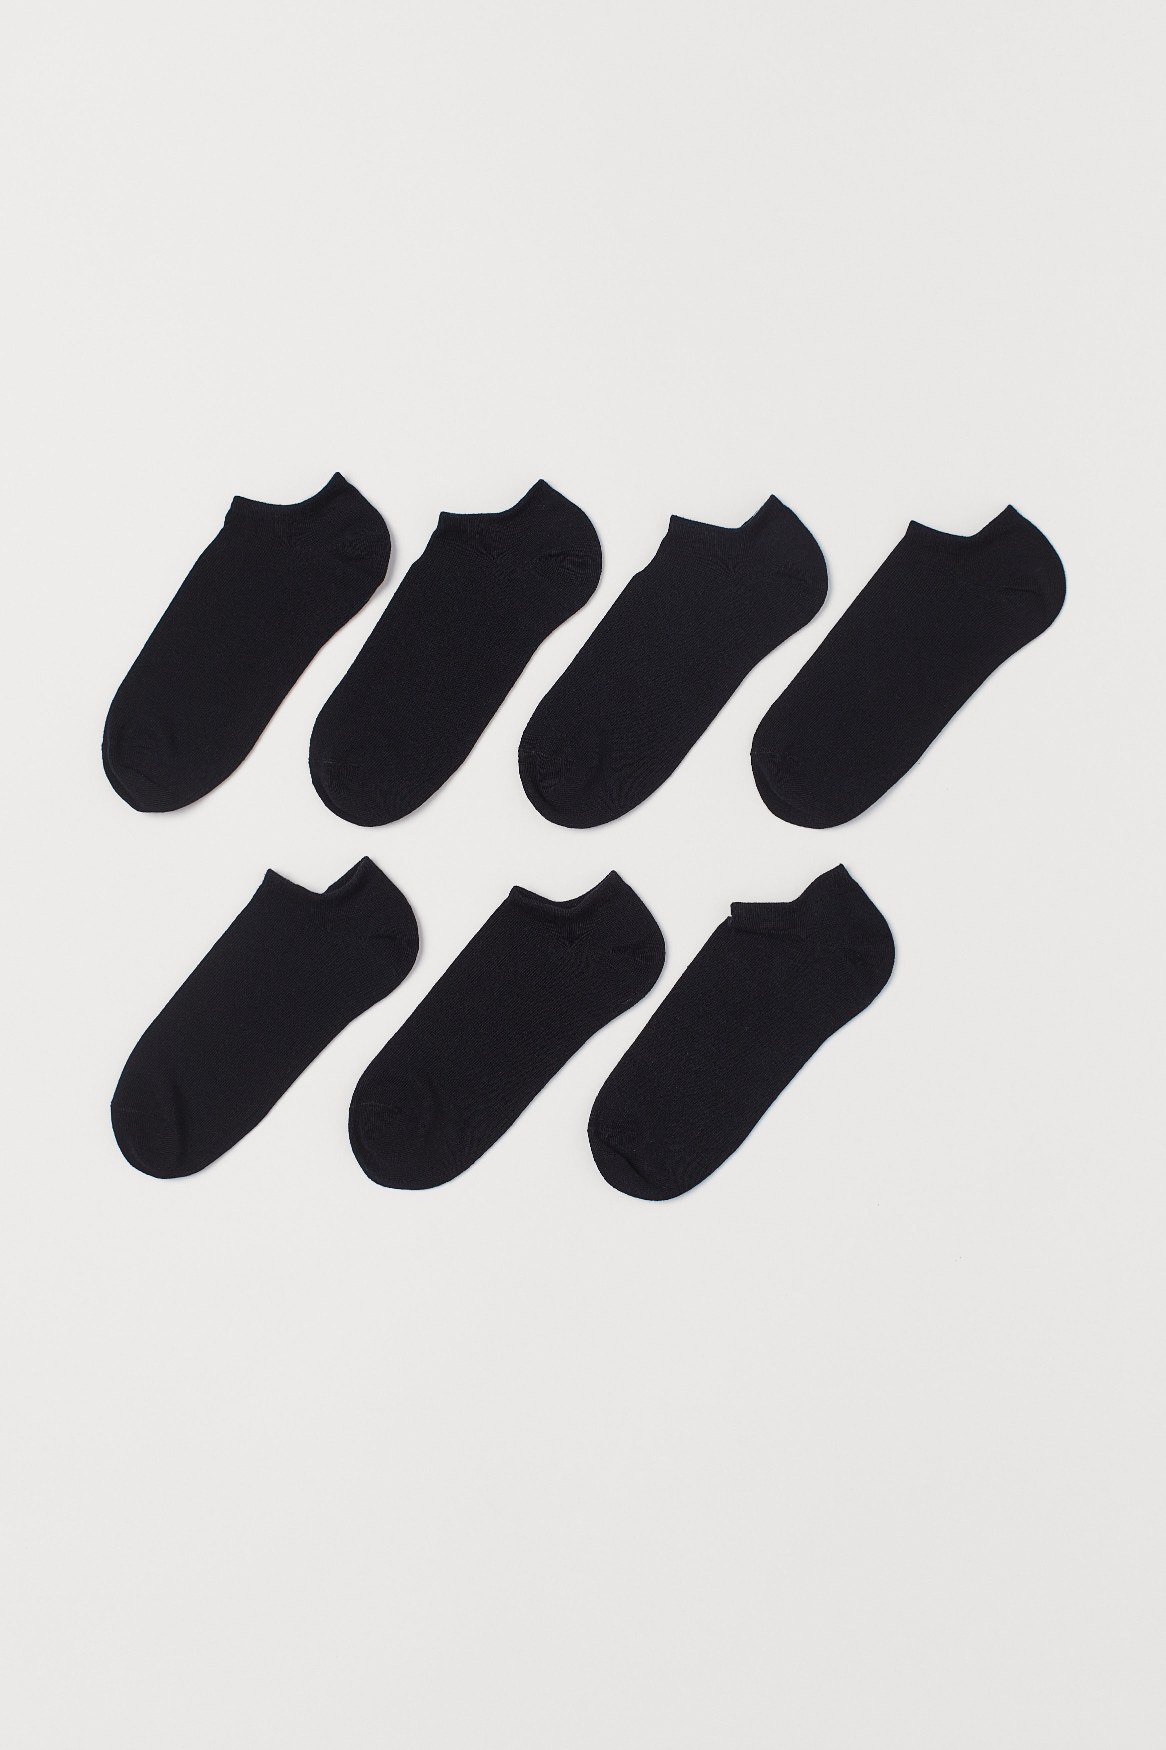

In [115]:
image_list[1]

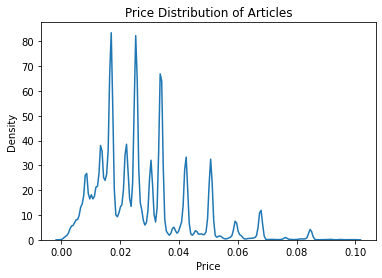

In [88]:
price_data = price.toPandas()
price_data = price_data[price_data["price"] <= 0.1]
ax = sns.kdeplot(x = "price", data = price_data)
ax.set_xlabel("Price")
ax.set_title("Price Distribution of Articles")
plt.show()